In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import dask
import pandas as pd

from eofs.xarray import Eof
from eofs.examples import example_data_path

In [9]:
# Part 1 skill check 

#ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP', chunks = {'time':'500MB'})

#variables =['Total_column_water_vapour_surface_Mixed_intervals_Average', 'Sea_surface_temperature_surface_Mixed_intervals_Average']

#ds = ds[variables].sel(lat=slice(65, -65, 4), lon=slice(120, 300, 4))

#ds.to_netcdf('raw_data.nc')

ds = xr.open_dataset('raw_data.nc')

mask = ds['Sea_surface_temperature_surface_Mixed_intervals_Average'] > 0
mask = mask.compute()
ds_masked = ds.where(mask, drop=True)

ds_masked_avgs = ds_masked.mean(dim='time')


/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


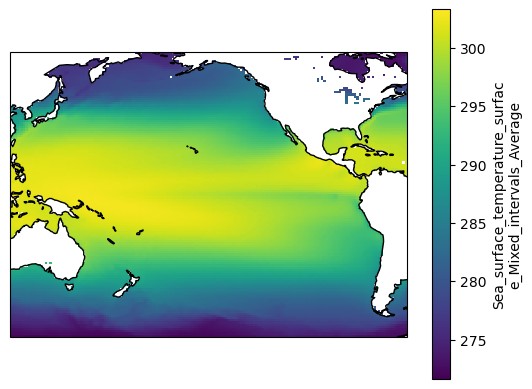

In [10]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
ds_masked_avgs['Sea_surface_temperature_surface_Mixed_intervals_Average'].plot(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')

/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


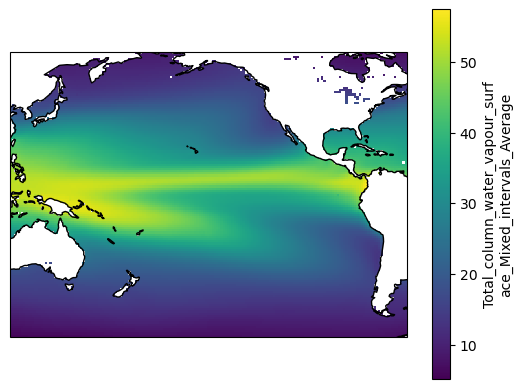

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
ds_masked_avgs['Total_column_water_vapour_surface_Mixed_intervals_Average'].plot(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')

In [ ]:
#### Part 2

### 1. Deseasonalize the data by removing the mean monthly anomaly from the annual mean from each point. ----- this seems like an incorrect interpretation of what we are actually doing, which is subtracting the long-term mean from the actual mean?
### 2. Detrend (get rid of any longterm variation)
### 3. Standardize the SST Anomalies. Subtract the long-term mean and divide by the standard deviation


#### Part 3

#Perform an EOF analysis

#Part 4

# Plot the percent of variance explained by the first 10 EOFs

# Part 5

#Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient using xarray.corr of the reconstructed monthly time series and observed SST time series

# Part 6

#Compute a map of Pearsn's correlation coefficient between SST EOF1 and monthly mean detrended, deasonalized, and standardized  monthly mean column water vapor anomalies

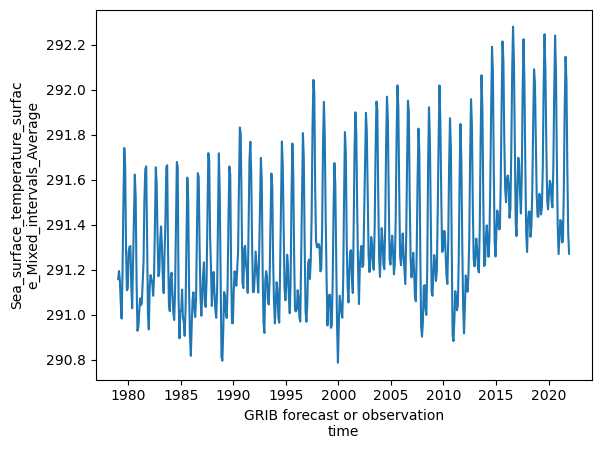

In [12]:
ds_masked['Sea_surface_temperature_surface_Mixed_intervals_Average'].mean(dim=['lat','lon']).plot()

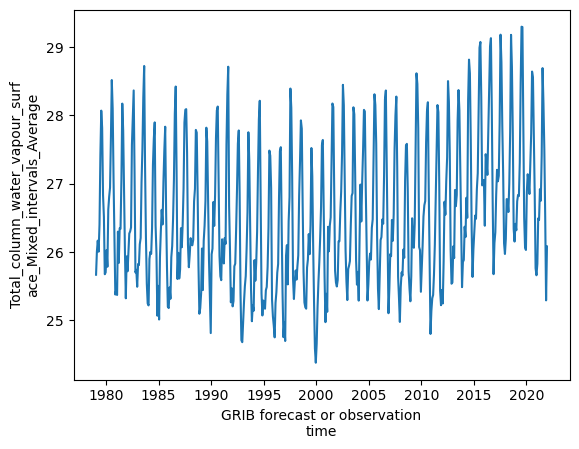

In [13]:
ds_masked['Total_column_water_vapour_surface_Mixed_intervals_Average'].mean(dim=['lat','lon']).plot()

In [158]:
#Deseasonlize the data
# "The most prominent feature of climate data is the annual cycle called climatology. The climatology represents the seasonal cycle and generally consists of one value in each month.""

clm = ds_masked.groupby('time.month').mean(dim='time') #groupby the same month over all years to find the mean values of that month to show the climatology. Mean monthly data.
anm = (clm - ds_masked.groupby('time.month')) #subtract the monthly grouped data over all yers by the average for each month over all years. This will show anomaly data. Anomaly is defined as any deviation from climatology.This is the monthly anomaly data./
#### reversed from the coding example based on instructions. 


##this seemed to be a waste of time! But I am keeping in case it wasn't. 
#annual_mean = ds_masked.groupby('time.year').mean(dim='time') #compute the annual mean of each year
#subtract he annual mean from the monthly anomaly mean
#anm_year = anm.groupby('time.year') #group anomaly data by year
#deseasonalized_data =  annual_mean - anm_year
#sst_data = deseasonalized_data['Sea_surface_temperature_surface_Mixed_intervals_Average']
#wv_data = deseasonalized_data['Total_column_water_vapour_surface_Mixed_intervals_Average']

sst_data = anm['Sea_surface_temperature_surface_Mixed_intervals_Average']

wv_data = anm['Total_column_water_vapour_surface_Mixed_intervals_Average']


In [159]:
#detrend

 # -- Detrending
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# -- Running mean sst. 
rd_sst_data = detrend_dim(sst_data,'time',1)

# total column water vapor
rd_wv_data = detrend_dim(wv_data,'time',1)


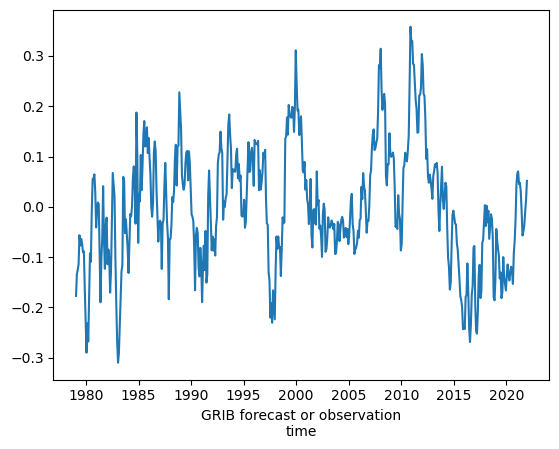

In [160]:
rd_sst_data.mean(dim=['lat','lon']).plot()


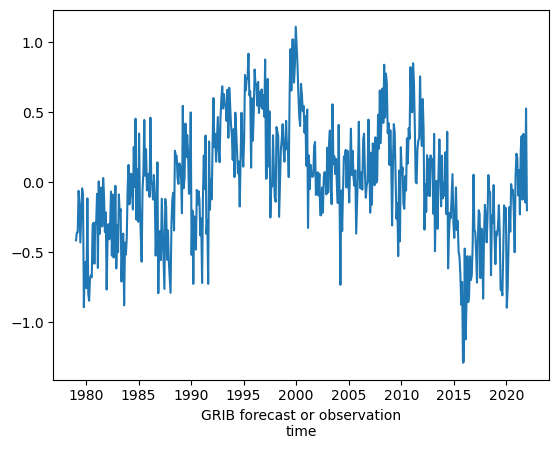

In [161]:
rd_wv_data.mean(dim=['lat','lon']).plot()

In [162]:
## standardize (divide by standard deviation). use the detrended data

std_sst = rd_sst_data.std(dim='time')

stndrd_sst = rd_sst_data/std_sst


std_wv = rd_wv_data.std(dim='time')

stndrd_wv = rd_wv_data/std_wv


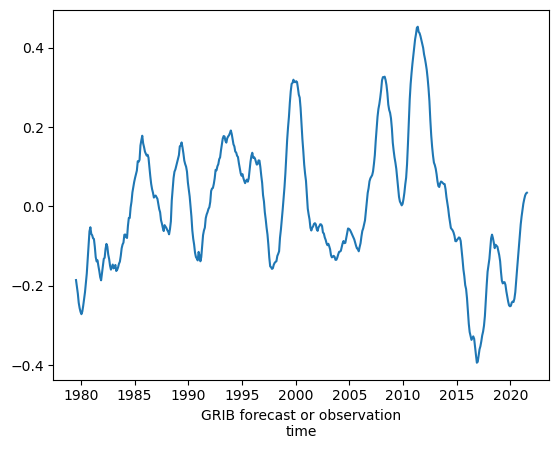

In [163]:
stndrd_sst_smooth = stndrd_sst.rolling(time=12, center=True).mean()

stndrd_sst_smooth.mean(dim=['lat','lon']).plot()

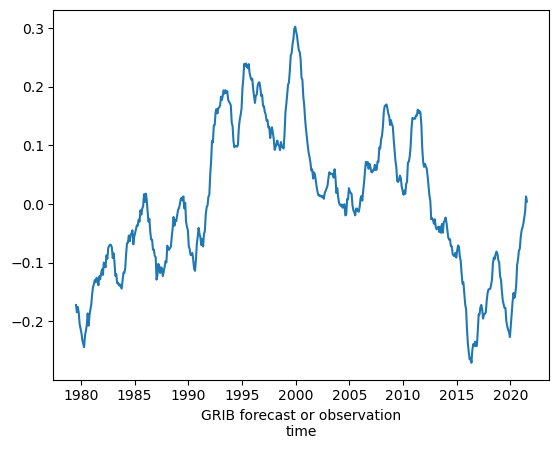

In [164]:
stndrd_wv_smooth = stndrd_wv.rolling(time=12, center=True).mean()
stndrd_wv_smooth.mean(dim=['lat','lon']).plot()


In [166]:
#3) Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

import numpy as np
import pandas as pd
import xarray as xr
import os
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

import geocat.viz.util as gvutil

from geocat.comp import eofunc_eofs, eofunc_pcs


# ----- Parameter setting ------
ystr = 1979
yend = 2021

#65°N to 65°S, 120°E to 60°W)
latS = -65.
latN = 65.
lonW = 120.
lonE = 360 - 60.

neof = 5


In [167]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path


# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(stndrd_sst.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis] #weighing based on the area
solver = Eof(stndrd_sst, weights=wgts)

In [168]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof5 = solver.eofsAsCorrelation(neofs=5) #specify the number of EOFs (5). Express as a correlation coefficient. 
pc5 = solver.pcs(npcs=5, pcscaling=1)

Text(0.5, 1.0, 'EOF1 expressed as correlation')

/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


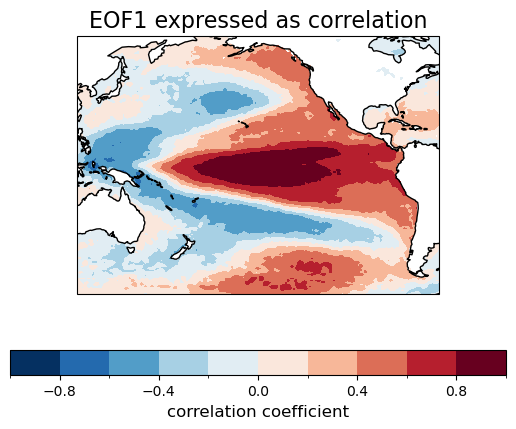

In [169]:
# Plot the leading EOF expressed as correlation in the Pacific domain. Using the sample code:
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof5[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 expressed as correlation', fontsize=16)


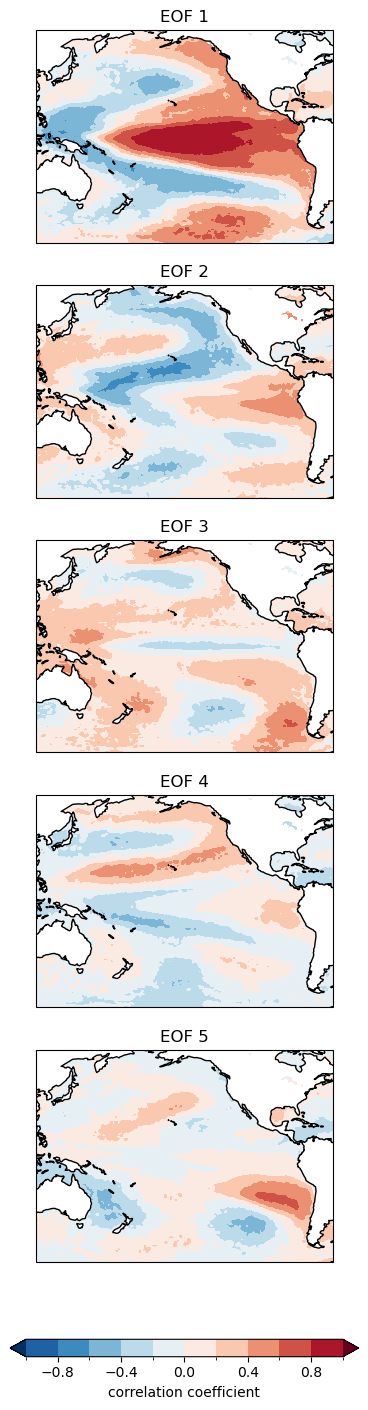

In [170]:
# Step 4: Plot the First 5 EOFs
fig, axs = plt.subplots(5, 1, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=190)})

for i in range(5):
    ax = axs[i]
    eof = eof5.sel(mode=i)
    
    # Plot EOF as a contour map
    fill5 = eof.plot.contourf(ax=ax, levels=clevs, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
    
    ax.coastlines()
    ax.set_title(f'EOF {i+1}')

fig.colorbar(fill5, ax=axs[:], orientation='horizontal', label = 'correlation coefficient', shrink=.3, pad=.05)

plt.show()

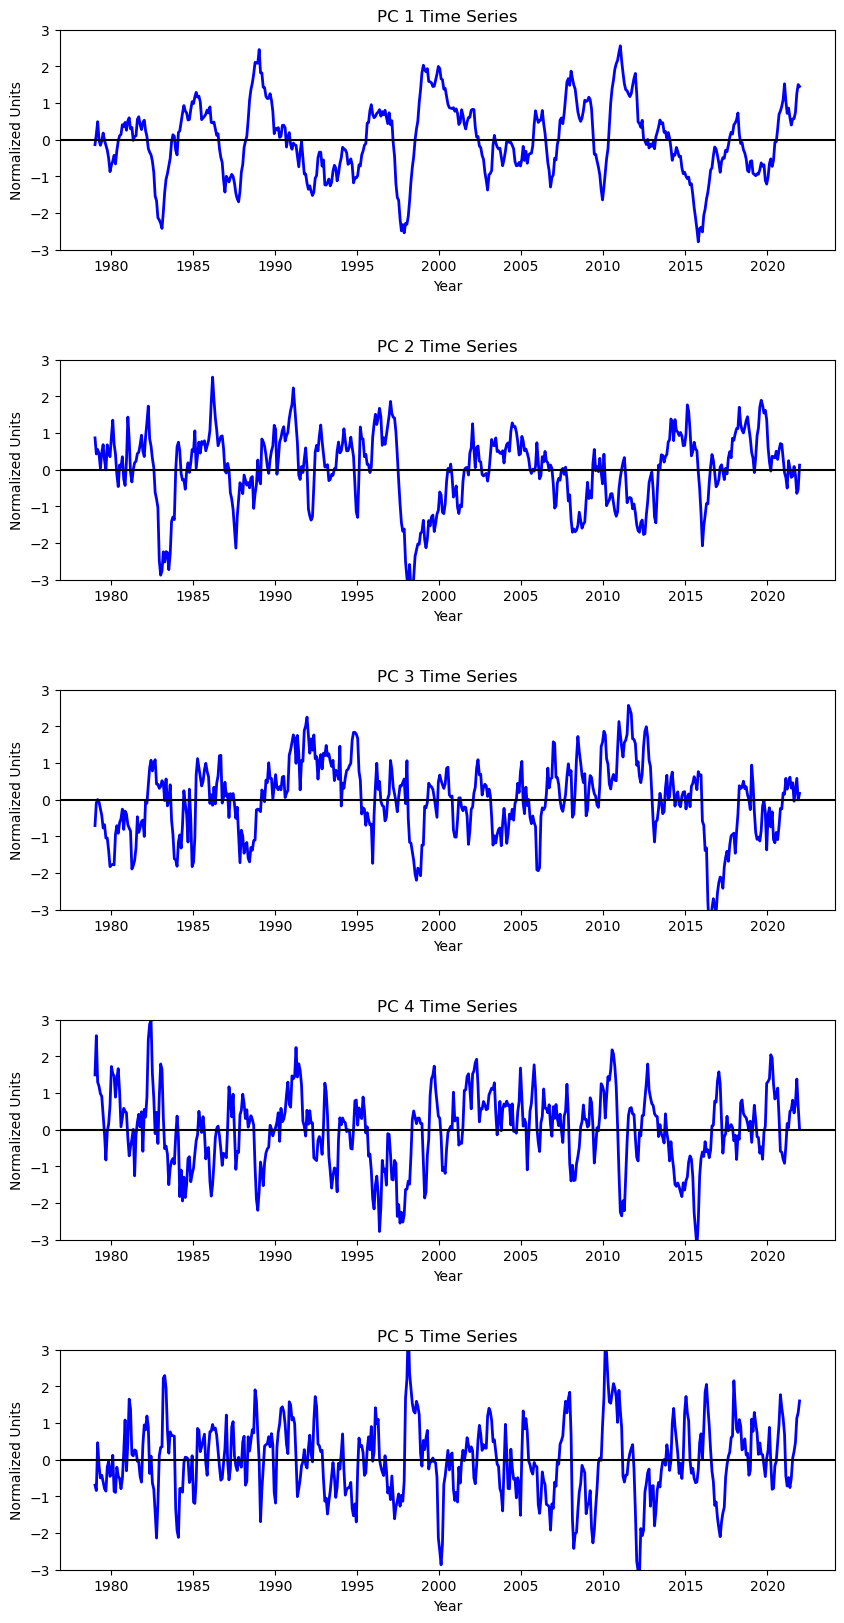

In [171]:
# Plot the second PC time series.
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

for i in range(5):
    ax = axs[i]
    pc5[:, i].plot(ax=ax, color='b', linewidth=2)
    ax.axhline(0, color='k')
    ax.set_ylim(-3, 3)
    ax.set_xlabel('Year')
    ax.set_ylabel('Normalized Units')
    ax.set_title(f'PC {i+1} Time Series')
plt.subplots_adjust(hspace=0.5)
plt.show()
#pc5 = solver.pcs(npcs=5, pcscaling=1)

#where it is high, that is where the map is highly correlated with the spatial EOF map. Where it is low, it is negatively correlated. The PC is identifying instances of variability. 

(2.508082376678861e-31, 19.282028428541317)

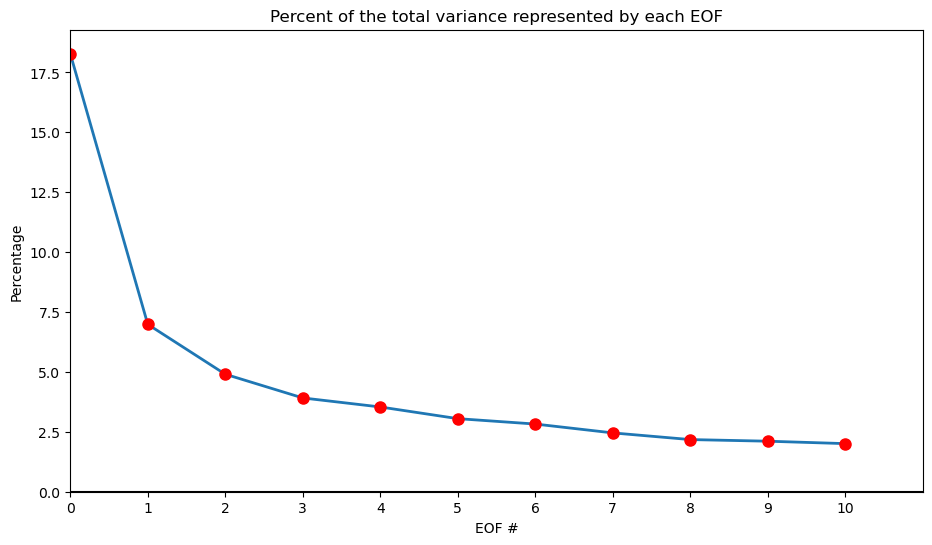

In [183]:
# 4) Plot the percent of variance explained by the first 10 EOFs.
#(13.4) in chapter is the formula for percentage of variance is expressed by the share of total variation over its eigenvalue multiplied by 100. To me, it looks like the variance fraction is doing the same, but not multiplying.
#so to get the %, multiply to fraction by 100

varfrac = solver.varianceFraction()
percent_variance = varfrac*100

# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(0, 11)
plt.plot(eof_num, percent_variance[0:11], linewidth=2)
plt.plot(eof_num, percent_variance[0:11], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(0, 11))
plt.title('Percent of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Percentage')
plt.xlim(0, 11)
plt.ylim(np.min(percent_variance), np.max(percent_variance)+1)


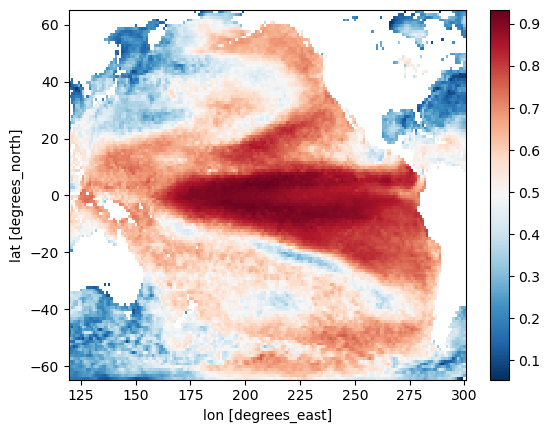

In [213]:
#5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.
reconstruction = solver.reconstructedField(5)
pearson = xr.corr(stndrd_sst, reconstruction, dim='time')
pearson.plot(cmap=plt.cm.RdBu_r)

/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


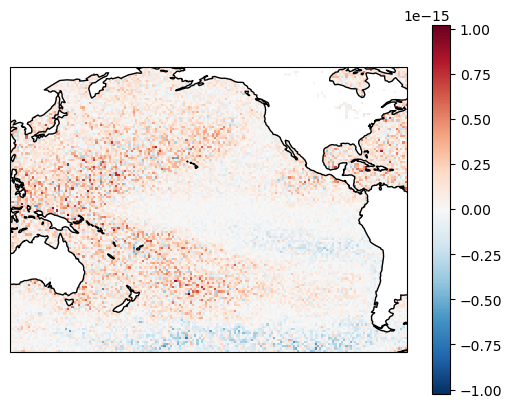

In [214]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
stndrd_sst.mean(dim='time').plot(ax=ax, cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')

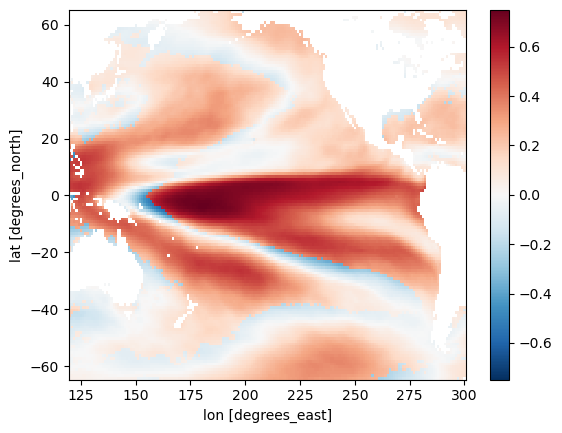

In [218]:
#6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot).  See anything interesting?

wv_unmask = ds['Total_column_water_vapour_surface_Mixed_intervals_Average'].mean(dim=['lat','lon'])
clm_unmask = wv_unmask.groupby('time.month').mean(dim='time') 
wv_anm_unmask = (clm_unmask - wv_unmask.groupby('time.month'))
# total column water vapor
anm_wv_data = detrend_dim(wv_anm_unmask,'time',1)
std_anm_wv = anm_wv_data.std(dim='time')

stndrd_anm_wv = rd_wv_data/std_wv



recon_eof1 = solver.reconstructedField(1)
pearson_eof1 = xr.corr(stndrd_anm_wv, recon_eof1, dim='time')
pearson_eof1.plot()